<a href="https://colab.research.google.com/github/zhaomargot/domestic_airline_ridership/blob/main/domestic_airlineridership_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Margot Zhao
DSO424
HW #2

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import * # from plotnine library import all functions
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [ ]:
# (1) scrape data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
raw_data = pd.read_html("https://www.transtats.bts.gov/Data_Elements.aspx", match="Year")

# (2) clean data and put into dataframe format
ogdf = pd.DataFrame.from_records(raw_data[1])
# remove the annual totals (finding rows where month column = "total")
ogdf = ogdf.drop(ogdf[ogdf["Month"] == "TOTAL"].index)
# reset index after removing rows
ogdf = ogdf.reset_index()
ogdf = ogdf.drop(columns=["index"])
# drop data after april 2022, index = 233
df = ogdf[:234]
print(df.tail())
print(ogdf.tail())
# last data point in "df" is march 2022
# dataframe "ogdf" has data until nov 2022 (for use in #16)

     Year Month  DOMESTIC  INTERNATIONAL     TOTAL
229  2021    11  59779348       10185722  69965070
230  2021    12  59535445       12311172  71846617
231  2022     1  45814651       10135600  55950251
232  2022     2  49076378        9291602  58367980
233  2022     3  64610376       13267214  77877590
     Year Month  DOMESTIC  INTERNATIONAL     TOTAL
237  2022     7  69422005       20032525  89454530
238  2022     8  66510671       18828719  85339390
239  2022     9  63131368       16125630  79256998
240  2022    10  67928141       16138092  84066233
241  2022    11  63526476       15385435  78911911


<ipython-input-3-98ee981ff3a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98ee981ff3a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     Year Month  DOMESTIC  INTERNATIONAL     TOTAL  Time  Trend
0    2002    10  48054917        9578435  57633352     1      1
1    2002    11  44850246        9016535  53866781     2      2
2    2002    12  49684353       10038794  59723147     3      3
3    2003     1  43032450        9726436  52758886     4      4
4    2003     2  41166780        8283372  49450152     5      5
..    ...   ...       ...            ...       ...   ...    ...
229  2021    11  59779348       10185722  69965070   230    230
230  2021    12  59535445       12311172  71846617   231    231
231  2022     1  45814651       10135600  55950251   232    232
232  2022     2  49076378        9291602  58367980   233    233
233  2022     3  64610376       13267214  77877590   234    234

[234 rows x 7 columns]


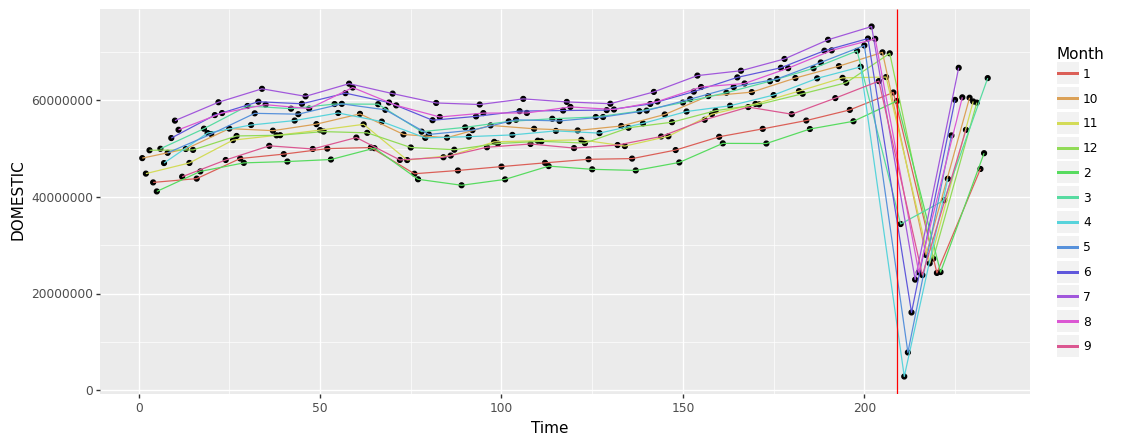

<ggplot: (8761472407471)>

In [ ]:
# (3) create 2 new columns (features): "time" and "trend"
# assign consecutive integers as values
df["Time"] = range(1,235)
#df["Time"] = df["Time"].astype(float)
df["Trend"] = range(1,235)
#df["Trend"] = df["Trend"].astype(float)
print(df)

# (4) plot monthly domestic air passenger data
# come back and fix order of the legend
ggplot(df, aes("Time","DOMESTIC")) + geom_point() + geom_line(aes(group="Month", color="Month")) + geom_vline(xintercept=209, color='red') + theme(figure_size=(12,5))

# (5) Patterns in the data: Overall, there is a positive trend — there is an increased demand for domestic air passengers over time.
# There is a slight downturn in the middle of the 50 and 100 unit marks on the x-axis (representing 70 or 80 months after October 2002),
# which may correspond with the 2008 financial recession and the ensueing drop in purchasing power that may have reduced the number of domestic air passengers.
# Additionally, there is a distinct downturn in domestic air passengers immediately past the red line representing the beginning of the COVID-19 pandemic, in March of 2020.
# The most recent months of the data show some level of recovery, as the number of domestic air passengers begins to approach previous levels.

<ipython-input-4-db1d9e472cc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-db1d9e472cc1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-db1d9e472cc1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                            OLS Regression Results                            
Dep. Variable:         precovDOMESTIC   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     60.11
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           5.49e-59
Time:                        08:36:19   Log-Likelihood:                -3421.1
No. Observations:                 209   AIC:                             6868.
Df Residuals:                     196   BIC:                             6912.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        4.26e+07   8.52e+05     50.

/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


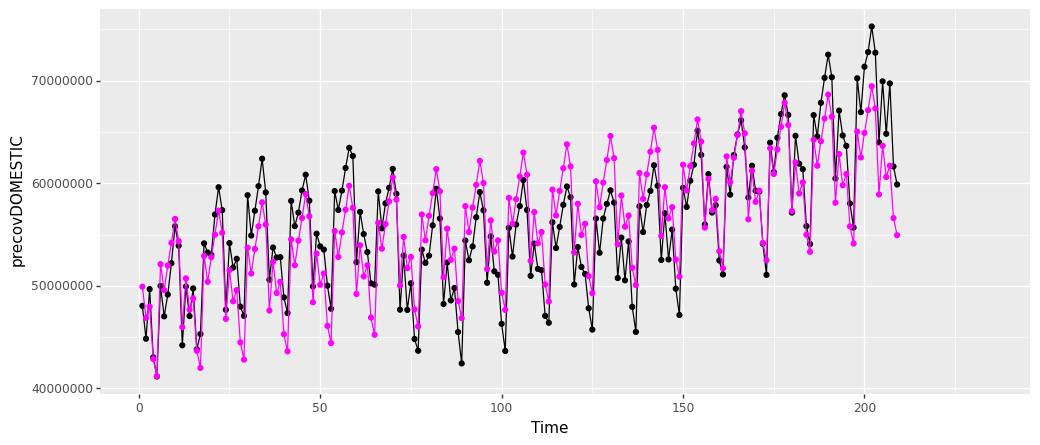

<ggplot: (8761469111275)>

In [ ]:
# (6) Pre-COVID regression model 1
# shows linear trend & monthly seasonality for data before March 2020
# create df with only pre-covid data, use index 209 as equal to march 2020
# precov_df = df[:209]

# create model
df["precovDOMESTIC"] = df.loc[:208, ["DOMESTIC"]]
# M1 = smf.ols('DOMESTIC ~ Trend + C(Month)',data=precov_df).fit()
M1 = smf.ols('precovDOMESTIC ~ Trend + C(Month)', data=df).fit()
print(M1.summary())
# save fitted values and residuals
# precov_df['M1'] = M1.fittedvalues
# precov_df['M1residuals'] = M1.resid
df['M1'] = M1.fittedvalues
df['M1residuals'] = M1.resid


# (7) plot pre-covid data and overlay fitted values
'''
(
    ggplot(precov_df,aes('Time','DOMESTIC')) + geom_point() + geom_line()+ theme(figure_size=(12,5))+
geom_point(aes('Time','M1'),color='magenta') + geom_line(aes('Time','M1'),color='magenta')
)
'''
(
    ggplot(df,aes('Time','precovDOMESTIC')) + geom_point() + geom_line()+ theme(figure_size=(12,5))+
geom_point(aes('Time','M1'),color='magenta') + geom_line(aes('Time','M1'),color='magenta')
)


In [ ]:
# (8) accuracy metrics
# MSE = mean((actual_y - predicted_y)^2)
# RMSE = sqrt(MSE) = sqrt(mean((actual_y - predicted_y)^2))
# MAPE = mean(abs((actual_y - predicted_y)/actual_y)) * 100 %

# Create a function that calculates RMSE
def rmse(actual_y,predicted_y):
    return round(np.sqrt(((actual_y - predicted_y)**2).mean()),2)

# Create a function that calculates MAPE
def mape(actual_y,predicted_y):
    return round((abs((actual_y - predicted_y)/actual_y)).mean() * 100,2)

# actual_y = precov_df["DOMESTIC"]
actual_y = df["precovDOMESTIC"]
# predicted_y = precov_df["M1"]
predicted_y = df["M1"]

print('RMSE =',rmse(actual_y,predicted_y))
print('MAPE =',mape(actual_y,predicted_y), '%')

# mean absolute percentage error: 4.94%, slightly higher than goal of 5%

RMSE = 3109873.51
MAPE = 4.94 %


/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


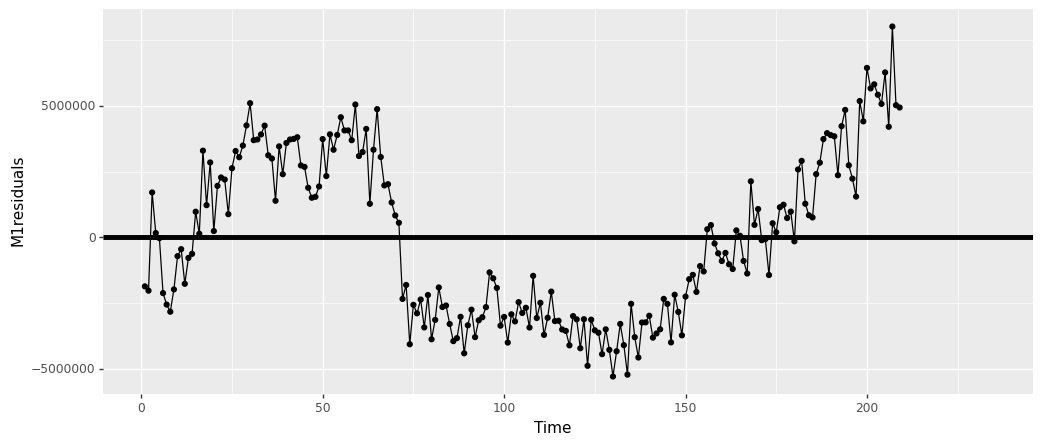

<ggplot: (8761469129482)>

In [ ]:
# (9) interpreting residuals plot & acf plot
# graph of residuals
'''
(
    ggplot(precov_df,aes('Time','M1residuals')) + geom_point() + geom_line()  + geom_hline(yintercept=0,size=2) + theme(figure_size=(12,5))

)
'''
(
    ggplot(df,aes('Time','M1residuals')) + geom_point() + geom_line()  + geom_hline(yintercept=0,size=2) + theme(figure_size=(12,5))

)

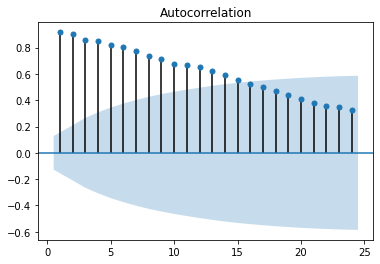

In [ ]:
# acf graph
plot_acf(df['M1residuals'],missing='drop',zero=False);
# slowly decaying ACF

# Therefore the performance of the model may not be adequate, as future values in the time series are heavily correlated with past values.

<ipython-input-8-8533744d82d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-8-8533744d82d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-8-8533744d82d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-8-8533744d82d9>:10:

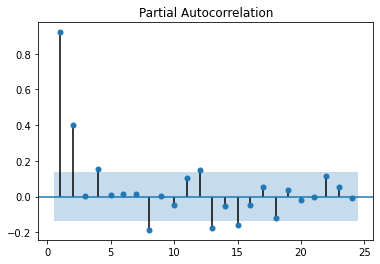

In [ ]:
# pacf graph
plot_pacf(df.M1residuals[df['M1residuals'].notna()],zero=False);
# pacf shows spikes at lag 1, 2, 4, 8, 12, 13

# (10) create features for the model based on the lags of air passenger demand
# include lag1, lag2, lag4, lag8, lag12, lag13 to capture/model the cyclical component
df["DomesticLag1"] = df["DOMESTIC"].shift(1)
df["DomesticLag2"] = df["DOMESTIC"].shift(2)
df["DomesticLag4"] = df["DOMESTIC"].shift(4)
df["DomesticLag8"] = df["DOMESTIC"].shift(8)
df["DomesticLag12"] = df["DOMESTIC"].shift(12)
df["DomesticLag13"] = df["DOMESTIC"].shift(13)


                            OLS Regression Results                            
Dep. Variable:         precovDOMESTIC   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     421.3
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          5.65e-135
Time:                        08:36:38   Log-Likelihood:                -2984.1
No. Observations:                 196   AIC:                             6006.
Df Residuals:                     177   BIC:                             6069.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.449e+06   1.42e+06     -1.

<ipython-input-9-082dea1c6040>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-9-082dea1c6040>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: 

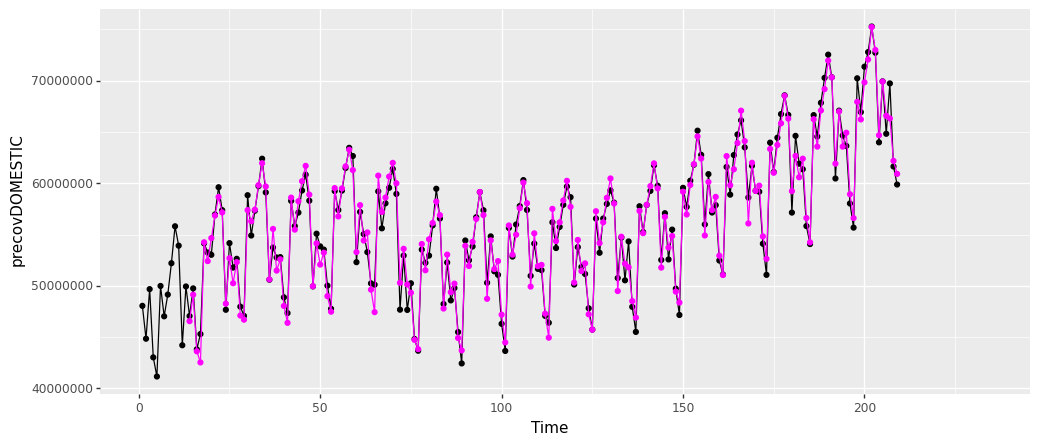

<ggplot: (8761472424445)>

In [ ]:
# (11) Pre-Covid regression model 2
# captures linear trend, monthly seasonality, cyclical component (lags)

M2 = smf.ols('precovDOMESTIC ~ Trend + C(Month) + DomesticLag1 + DomesticLag2 + DomesticLag4 + DomesticLag8 + DomesticLag12 + DomesticLag13', data=df).fit()
print(M2.summary())
df['M2'] = M2.fittedvalues
df['M2residuals'] = M2.resid

# (12) plot pre-covid data and overlay fitted values
(
    ggplot(df,aes('Time','precovDOMESTIC')) + geom_point() + geom_line()+ theme(figure_size=(12,5))+
geom_point(aes('Time','M2'),color='magenta') + geom_line(aes('Time','M2'),color='magenta')
)

In [ ]:
# (13) accuracy metrics
# RMSE = sqrt(MSE) = sqrt(mean((actual_y - predicted_y)^2))
# MAPE = mean(abs((actual_y - predicted_y)/actual_y)) * 100 %

# Create a function that calculates MAPE
def mape(actual_y,predicted_y):
    return round((abs((actual_y - predicted_y)/actual_y)).mean() * 100,2)

actual_y = df["DOMESTIC"]
predicted_y = df["M2"]

print('RMSE =',rmse(actual_y,predicted_y))
print('MAPE =',mape(actual_y,predicted_y), '%')

# mean absolute percentage error: 1.4%
# good level of accuracy, improves on percentage error from first model

RMSE = 990638.06
MAPE = 1.4 %


/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 38 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 38 rows containing missing values.


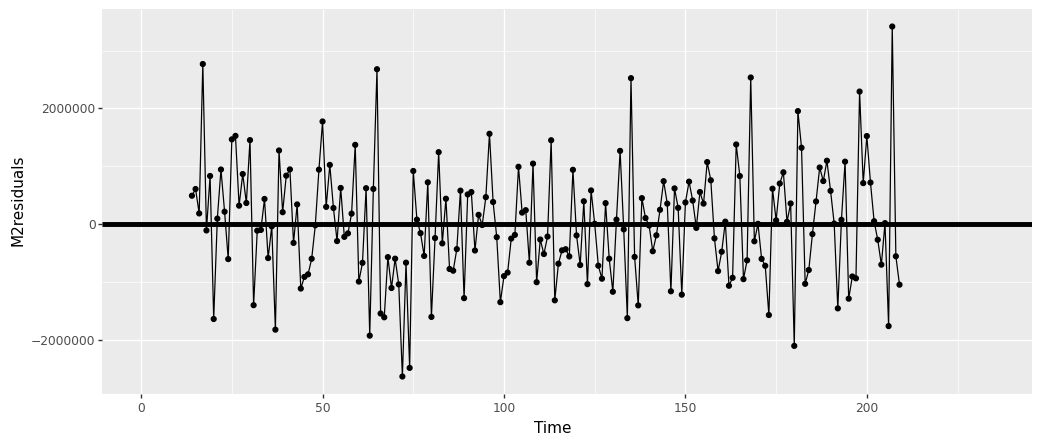

<ggplot: (8761463751292)>

In [ ]:
#(14) residuals plot
(
    ggplot(df,aes('Time','M2residuals')) + geom_point() + geom_line()  + geom_hline(yintercept=0,size=2) + theme(figure_size=(12,5))

)

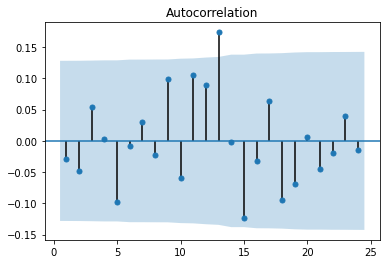

In [ ]:
# acf graph
plot_acf(df['M2residuals'],missing='drop',zero=False);
# slowly decaying ACF

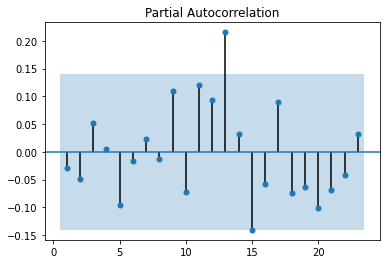

In [ ]:
# pacf graph
plot_pacf(df.M2residuals[df['M2residuals'].notna()],zero=False);

# Is the performance of the model adequate?
# Still shows a lag at 12

In [ ]:
# (15) impact of covid on the domestic air passenger demand in terms of numbers of passeners & as a percentage
# create predictions
df.loc[209:, ["M2Pred"]] = M2.predict(df)
print(df["M2Pred"])

# total impact of COVID = sum of residuals during COVID
df["M3residuals"] = df["DOMESTIC"] - df["M2Pred"]

# number of lost air passenger travel because of COVID: 1.184823e+08
print(df.loc[209:,['M3residuals']].sum())
print()

# percentage of air passenger travel because of COVID
print((df.loc[209:,['M3residuals']].sum() / df.loc[209:,['M2Pred']].sum()) * 100)


0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
229    5.837898e+07
230    5.898423e+07
231    5.408773e+07
232    4.742448e+07
233    5.807765e+07
Name: M2Pred, Length: 234, dtype: float64
M3residuals   -3.000930e+07
dtype: float64

M2Pred        NaN
M3residuals   NaN
dtype: float64


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-4ab9d69c881a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-16-35710ecacbd6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-16-35710ecacbd6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33


<ipython-input-16-35710ecacbd6>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     Year Month  DOMESTIC  INTERNATIONAL     TOTAL  Time  Trend  \
214  2020     8  24431822        2298093  26729915   215    215   
215  2020     9  23854772        2280598  26135370   216    216   
216  2020    10  28027209        2969651  30996860   217    217   
217  2020    11  26294514        3553139  29847653   218    218   
218  2020    12  27264199        4763815  32028014   219    219   
219  2021     1  24305908        4504353  28810261   220    220   
220  2021     2  24483505        2994388  27477893   221    221   
221  2021     3  39343495        4616871  43960366   222    222   
222  2021     4  43798946        5499899  49298845   223    223   
223  2021     5  52752164        7010140  59762304   224    224   
224  2021     6  60110694        8974037  69084731   225    225   
225  2021     7  66741175       10811152  77552327   226    226   
226  2021     8  60632081       10515856  71147937   227    227   
227  2021     9  53903524        8247453  62150977   228    22

/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 217 rows containing missing values.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 217 rows containing missing values.


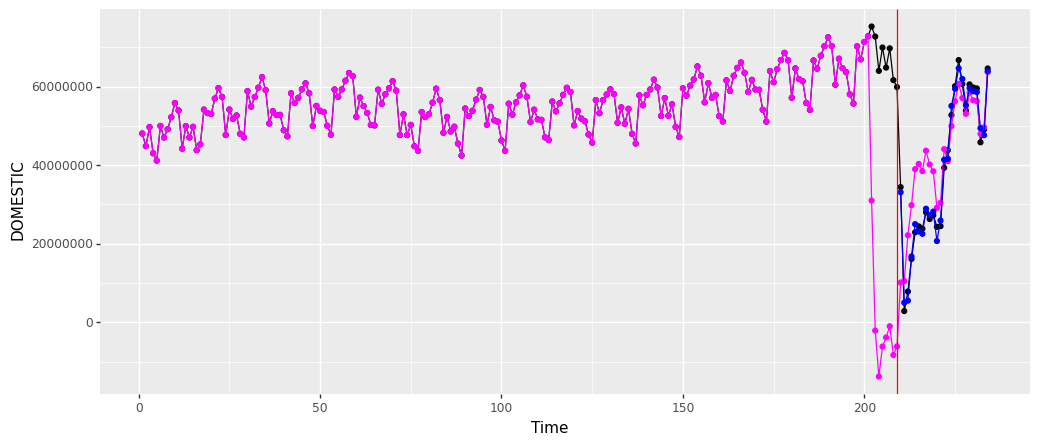

<ggplot: (8761463711970)>

In [ ]:
# (16) domestic air passenger recovery?

# graph all monthly data from oct 2002 to nov 2022
# use ogdf (data until nov22)
# copy over columns from df
ogdf["precovDOMESTIC"] = df["precovDOMESTIC"]
ogdf["Time"] = df["Time"]
ogdf["Trend"] = df["Trend"]
ogdf["M2Pred"] = df["M2Pred"]
ogdf['DomesticLag1'] = df['DomesticLag1']
ogdf['DomesticLag2'] = df['DomesticLag2']
ogdf['DomesticLag4'] = df['DomesticLag4']
ogdf['DomesticLag8'] = df['DomesticLag8']
ogdf['DomesticLag12'] = df['DomesticLag12']
ogdf['DomesticLag13'] = df['DomesticLag13']

# forecasts for post-COVID period
df["postcovDOMESTIC"] = df.loc[209:, ["DOMESTIC"]]
M3 = smf.ols('postcovDOMESTIC ~ Trend + C(Month) + DomesticLag1 + DomesticLag2 + DomesticLag4 + DomesticLag8 + DomesticLag12 + DomesticLag13', data=df).fit()
df['M3'] = M3.fittedvalues

# h = forecast horizon
h = ogdf['precovDOMESTIC'].isna().sum()
print(h)

list(range(len(df) - h, len(df)))
for i in range(len(df) - h,len(df)):
    ogdf.loc[i,'DomesticLag1'] = ogdf.loc[i-1,'precovDOMESTIC']
    ogdf.loc[i,'DomesticLag2'] = ogdf.loc[i-2,'precovDOMESTIC']
    ogdf.loc[i,'DomesticLag4'] = ogdf.loc[i-4,'precovDOMESTIC']
    ogdf.loc[i,'DomesticLag8'] = ogdf.loc[i-8,'precovDOMESTIC']
    ogdf.loc[i,'DomesticLag12'] = ogdf.loc[i-12,'precovDOMESTIC']
    ogdf.loc[i,'DomesticLag13'] = ogdf.loc[i-13,'precovDOMESTIC']
    ogdf.loc[i,'M2'] = M2.predict(ogdf.iloc[[i]]).values
    ogdf.loc[i,'M3'] = M3.predict(ogdf.iloc[[i]]).values
    ogdf.loc[i,'precovDOMESTIC'] = ogdf.loc[i,'M3']

df["M3Pred"] = M3.predict(df)
ogdf["M3"] = df["M3"]
ogdf["M2"] = df["M2"]
ogdf["M2"] = M2.predict(ogdf)
ogdf["postcovDOMESTIC"] = df["postcovDOMESTIC"]
print(df.tail(20))
print(ogdf.tail(20))

# plot until nov 2022 (use ogdf) with forecasts
(
ggplot(ogdf,aes('Time','DOMESTIC')) + geom_point() + geom_line()+ theme(figure_size=(12,5)) +
geom_point(aes('Time','M2'),color='magenta') + geom_line(aes('Time','M2'),color='magenta') +
geom_point(aes('Time','M3'),color='blue') + geom_line(aes('Time','M3'),color='blue') +
geom_vline(xintercept = 209, color="red")
)


# conclusion: The airline industry has not yet fully recovered, as the actual domestic data is lower than the projected trajectory without COVID.
